In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix, f1_score

from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb

In [2]:
train = pd.read_csv('./data/train.csv')
greeks = pd.read_csv('./data/greeks.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [4]:
train = train.set_index('Id')
test = test.set_index('Id')
greeks = greeks.set_index('Id')

X = train.drop('Class', axis = 1)
y = train['Class']

In [5]:
print(y.value_counts())

0    509
1    108
Name: Class, dtype: int64


In [6]:
# Search for categorial features
print(X.dtypes[X.dtypes != float])


EJ    object
dtype: object


In [7]:
# Encode categorial object 'EJ' feature 

enc = OneHotEncoder()
enc.fit(X['EJ'].values.reshape(-1, 1))
onehot_cols = ['EJ' + '_' + x for x in enc.categories_[0]]

X[onehot_cols] = enc.transform(X['EJ'].values.reshape(-1, 1)).toarray()
X = X.drop('EJ', axis = 1)

test[onehot_cols] = enc.transform(test['EJ'].values.reshape(-1, 1)).toarray()
test = test.drop('EJ', axis = 1)

In [8]:
# Check which features are missing and how many missing data points are there

nas = X.isnull().sum()[X.isnull().sum() > 0]
nas

BQ    60
CB     2
CC     3
DU     1
EL    60
FC     1
FL     1
FS     2
GL     1
dtype: int64

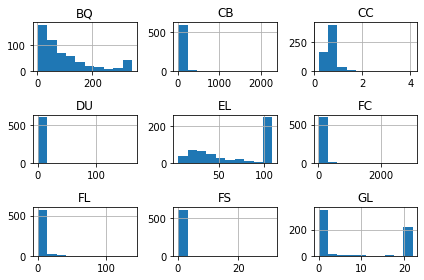

In [9]:
# Histogram of features with missing value for later comparison
X[nas.index].hist()
plt.tight_layout()

In [10]:
# Since the features which contain missing values are not normally-distributed, we will use iterative imputer. 
imp = KNNImputer(weights = 'distance', n_neighbors=20) # weight by distance but use many neighbors
X2 = pd.DataFrame(imp.fit_transform(X), index = X.index, columns = X.columns)

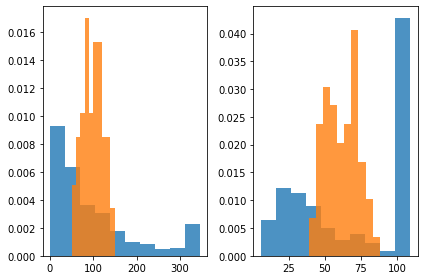

In [11]:
# Let's examine the distribution of the added values compared to the old ones
fig, axs = plt.subplots(nrows = 1, ncols = 2)
axs = axs.ravel()
for i, col in enumerate(nas[nas > 10].index):

    axs[i].hist(X2[~X[col].isna()][col].values, density = True, alpha = 0.8)
    axs[i].hist(X2[X[col].isna()][col].values, density = True, alpha = 0.8)

plt.tight_layout()

In [12]:
random_state = random_state=42

In [13]:
# Add features

epsilon = 1e-10

features = X.iloc[:, 0:-2].columns
l = []
for f1 in features:
    for f2 in features:
        name = f1+'/'+f2
        if f1 != f2 and name not in l:
            X[name] = X.loc[:, f1].values / (X.loc[:, f2].values + epsilon)
            test[name] = test.loc[:, f1].values / (test.loc[:, f2].values + epsilon)
            l.append(name)

X['Random'] = np.random.rand(X.shape[0], 1)
test['Random'] = np.random.rand(test.shape[0], 1)

In [44]:
skf = StratifiedShuffleSplit(n_splits=4, test_size=0.33, random_state=random_state)


models = {}
y_hats = {}
ys = {}
matrix = {}
score = {}


for i, (train_index, test_index) in enumerate(skf.split(X2, y)):  
    # Split
    X_train, X_val = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    # Add missing values
    imp = KNNImputer(weights = 'distance', n_neighbors=20).fit(X_train)

    X_train = pd.DataFrame(imp.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_val = pd.DataFrame(imp.transform(X_val), index = X_val.index, columns = X_val.columns)
    X_test = pd.DataFrame(imp.transform(test), index = test.index, columns = test.columns)

    # Scale data
    scaler = StandardScaler().fit(X_train)

    X_train = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_val = pd.DataFrame(scaler.transform(X_val), index = X_val.index, columns = X_val.columns)
    X_test = pd.DataFrame(scaler.transform(test), index = test.index, columns = test.columns)

    # train a gradient boost with high n_estimator, max_depth

    gb = GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 100, max_depth = 10)
    gb.fit(X_train, y_train)
    
    #param = {'num_leaves': 31, 'objective': 'binary', 'n_estimators':100,  'max_depth':10,}
    #param = {'is_unbalance':True, 'min_data_in_leaf':2}
    #gb = lgb.LGBMClassifier(**param).fit(X_train, y_train)
    
    # Predict
    yhat_train = gb.predict(X_train)
    yhat_val = gb.predict(X_val)
    yhat_test = gb.predict(X_test)

    # Store
    val_name = str(i) + '-val'
    train_name = str(i) + '-train'

    ys[train_name] = y_train
    y_hats[train_name] = yhat_train

    ys[val_name] = y_val
    y_hats[val_name] = yhat_val

    matrix[train_name] = confusion_matrix(y_train, yhat_train)
    matrix[val_name] = confusion_matrix(y_val, yhat_val)

    score[i] = [f1_score(yhat_train, y_train), f1_score(yhat_val, y_val)]

    models[i] = gb


KeyboardInterrupt: 

Text(0.5, 15.0, 'pred')

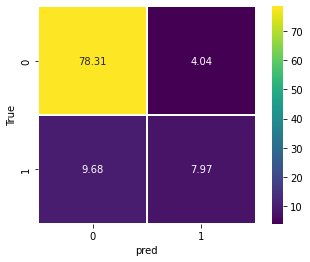

In [42]:
gb0_matrix = np.mean([matrix[x] for x in matrix if 'val' in x], axis = 0)
sns.heatmap(100*gb0_matrix/gb0_matrix.sum(), cmap = 'viridis', annot=True,  fmt = '.2f', square=1, linewidth=1.)
plt.ylabel('True')
plt.xlabel('pred')

In [43]:
score

{0: [1.0, 0.5294117647058824],
 1: [1.0, 0.5818181818181818],
 2: [1.0, 0.5666666666666667],
 3: [1.0, 0.47457627118644075]}

In [20]:
gb.get_params

<bound method LGBMModel.get_params of LGBMClassifier(metric='auc', n_estimators=500, num_leaves=10,
               objective='binary')>

In [ ]:
mean_importance = np.mean([models[x].feature_importances_ for x in models], axis = 0)
mean_importance = pd.Series(index = X.columns, data = mean_importance).sort_values(ascending=False)

In [ ]:
X = X.loc[:,mean_importance[mean_importance >= mean_importance['Random']].index]
test = test.loc[:, mean_importance[mean_importance >= mean_importance['Random']].index]

In [ ]:
skf = StratifiedShuffleSplit(n_splits=4, test_size=0.5, random_state=random_state)


models = {}
y_hats = {}
ys = {}
matrix = {}
score = {}


for i, (train_index, test_index) in enumerate(skf.split(X2, y)):  
    # Split
    X_train, X_val = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    # Add missing values
    imp = KNNImputer(weights = 'distance', n_neighbors=20).fit(X_train)

    X_train = pd.DataFrame(imp.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_val = pd.DataFrame(imp.transform(X_val), index = X_val.index, columns = X_val.columns)
    X_test = pd.DataFrame(imp.transform(test), index = test.index, columns = test.columns)

    # Scale data
    scaler = StandardScaler().fit(X_train)

    X_train = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_val = pd.DataFrame(scaler.transform(X_val), index = X_val.index, columns = X_val.columns)
    X_test = pd.DataFrame(scaler.transform(test), index = test.index, columns = test.columns)

    # train a gradient boost with high n_estimator, max_depth

    #gb = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 1000, max_depth = None)
    #gb.fit(X_train, y_train)
    
    param = {'num_leaves': 20, 'objective': 'binary', 'n_estimators':500,'metric':'auc'}
    gb = lgb.LGBMClassifier(**param).fit(X_train, y_train)
    
    # Predict
    yhat_train = gb.predict(X_train)
    yhat_val = gb.predict(X_val)
    yhat_test = gb.predict(X_test)

    # Store
    val_name = str(i) + '-val'
    train_name = str(i) + '-train'

    ys[train_name] = y_train
    y_hats[train_name] = yhat_train

    ys[val_name] = y_val
    y_hats[val_name] = yhat_val

    matrix[train_name] = confusion_matrix(y_train, yhat_train)
    matrix[val_name] = confusion_matrix(y_val, yhat_val)

    score[i] = [f1_score(yhat_train, y_train), f1_score(yhat_val, y_val)]

    models[i] = gb


In [ ]:
gb0_matrix = np.mean([matrix[x] for x in matrix if 'val' in x], axis = 0)
sns.heatmap(100*gb0_matrix/gb0_matrix.sum(), cmap = 'viridis', annot=True,  fmt = '.2f', square=1, linewidth=1.)
plt.ylabel('True')
plt.xlabel('pred')

In [ ]:
score

In [ ]:
mean_importance = np.mean([models[x].feature_importances_ for x in models], axis = 0)
mean_importance = pd.Series(index = X.columns, data = mean_importance).sort_values(ascending=False)

In [ ]:
mean_importance

In [ ]:
X_train.shape